In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# ✅ Paso 2: Importaciones
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset, DatasetDict
from peft import get_peft_model, LoraConfig, TaskType
from transformers import BitsAndBytesConfig
import torch
import json

In [3]:
# ✅ Paso 3: Cargar el dataset JSONL personalizado
from datasets import load_dataset

data_files = {
    'train': 'dataset_train_filtrado.jsonl',
    'validation': 'dataset_valid_filtrado.jsonl',
    'test': 'dataset_test_filtrado.jsonl'
}

raw_datasets = load_dataset('json', data_files=data_files)

# Mantener solo las primeras 20 filas en cada split
#raw_datasets['train'] = raw_datasets['train'].select(range(20))
#raw_datasets['validation'] = raw_datasets['validation'].select(range(20))
#raw_datasets['test'] = raw_datasets['test'].select(range(20))

# Opcional: verificar
print(raw_datasets['train'][:2])

{'repo': ['titilambert/pyfido', 'titilambert/pyfido'], 'path': ['pyfido/client.py', 'pyfido/client.py'], 'func_name': ['FidoClient._post_login_page', 'FidoClient._get_account_number'], 'original_string': ['def _post_login_page(self):\n        """Login to Janrain."""\n        # Prepare post data\n        data = {\n            "form": "signInForm",\n            "client_id": JANRAIN_CLIENT_ID,\n            "redirect_uri": "https://www.fido.ca/pages/#/",\n            "response_type": "token",\n            "locale": "en-US",\n            "userID": self.username,\n            "currentPassword": self.password,\n        }\n        # HTTP request\n        try:\n            raw_res = yield from self._session.post(LOGIN_URL,\n                                                    headers=self._headers,\n                                                    data=data,\n                                                    timeout=self._timeout)\n        except OSError:\n            raise PyFidoError("Can

In [4]:
raw_datasets.shape

{'train': (3220, 13), 'validation': (3723, 13), 'test': (3999, 13)}

In [5]:
raw_datasets['train']

Dataset({
    features: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'code_clean'],
    num_rows: 3220
})

In [6]:
raw_datasets['train']['code_clean'][:2]

["def _post_login_page(self):\n    data = {'form': 'signInForm', 'client_id': JANRAIN_CLIENT_ID, 'redirect_uri': 'https://www.fido.ca/pages/#/', 'response_type': 'token', 'locale': 'en-US', 'userID': self.username, 'currentPassword': self.password}\n    try:\n        raw_res = (yield from self._session.post(LOGIN_URL, headers=self._headers, data=data, timeout=self._timeout))\n    except OSError:\n        raise PyFidoError('Can not sign in')\n    return True",
 "def _get_account_number(self, token, uuid):\n    data = {'accessToken': token, 'uuid': uuid}\n    try:\n        raw_res = (yield from self._session.post(ACCOUNT_URL, data=data, headers=self._headers, timeout=self._timeout))\n    except OSError:\n        raise PyFidoError('Can not get account number')\n    try:\n        json_content = (yield from raw_res.json())\n        account_number = json_content.get('getCustomerAccounts', {}).get('accounts', [{}])[0].get('accountNumber')\n    except (OSError, ValueError):\n        raise PyFi

In [7]:
raw_datasets['train']['code'][:2]

['def _post_login_page(self):\n        """Login to Janrain."""\n        # Prepare post data\n        data = {\n            "form": "signInForm",\n            "client_id": JANRAIN_CLIENT_ID,\n            "redirect_uri": "https://www.fido.ca/pages/#/",\n            "response_type": "token",\n            "locale": "en-US",\n            "userID": self.username,\n            "currentPassword": self.password,\n        }\n        # HTTP request\n        try:\n            raw_res = yield from self._session.post(LOGIN_URL,\n                                                    headers=self._headers,\n                                                    data=data,\n                                                    timeout=self._timeout)\n        except OSError:\n            raise PyFidoError("Can not sign in")\n\n        return True',
 'def _get_account_number(self, token, uuid):\n        """Get fido account number."""\n        # Data\n        data = {"accessToken": token,\n                "uuid"

In [8]:
# ✅ Paso 4: Tokenizador
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
max_input_length = 512
max_target_length = 512



In [10]:
def preprocess_function(example):
    prompt = (
        "You are a professional Python developer. Your task is to add a clear, concise docstring and relevant inline comments "
        "to the following Python function. Do not modify the structure or logic of the code. Keep formatting, indentation, and line breaks exactly as they are. "
        "Return only the complete commented function, as valid Python code:\n\n"
        f"{example['code_clean']}\n\n### Return the commented version below:"
    )

    input = tokenizer(prompt, padding="max_length", truncation=True, max_length=max_input_length)
    target = tokenizer(example['code'], padding="max_length", truncation=True, max_length=max_target_length)


    input["labels"] = target["input_ids"]
    return input


In [11]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=False)

In [12]:
# ✅ Paso 6: Configurar modelo en 8-bit con LoRA para ahorrar RAM
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,  # o el modelo que uses
    device_map=None,  #"auto",       # o {"": "cpu"} si solo CPU
    torch_dtype=torch.float32,  # ya no es necesario usar float16
) #.to("cpu")

In [13]:
for name, module in model.named_modules():
    if "DenseReluDense" in name or "SelfAttention" in name:
        print(name)


encoder.block.0.layer.0.SelfAttention
encoder.block.0.layer.0.SelfAttention.q
encoder.block.0.layer.0.SelfAttention.k
encoder.block.0.layer.0.SelfAttention.v
encoder.block.0.layer.0.SelfAttention.o
encoder.block.0.layer.0.SelfAttention.relative_attention_bias
encoder.block.0.layer.1.DenseReluDense
encoder.block.0.layer.1.DenseReluDense.wi_0
encoder.block.0.layer.1.DenseReluDense.wi_1
encoder.block.0.layer.1.DenseReluDense.wo
encoder.block.0.layer.1.DenseReluDense.dropout
encoder.block.0.layer.1.DenseReluDense.act
encoder.block.1.layer.0.SelfAttention
encoder.block.1.layer.0.SelfAttention.q
encoder.block.1.layer.0.SelfAttention.k
encoder.block.1.layer.0.SelfAttention.v
encoder.block.1.layer.0.SelfAttention.o
encoder.block.1.layer.1.DenseReluDense
encoder.block.1.layer.1.DenseReluDense.wi_0
encoder.block.1.layer.1.DenseReluDense.wi_1
encoder.block.1.layer.1.DenseReluDense.wo
encoder.block.1.layer.1.DenseReluDense.dropout
encoder.block.1.layer.1.DenseReluDense.act
encoder.block.2.layer.0.

In [14]:
# Paso 7: Configurar LoRA para entrenamiento eficiente
# usamos LoRA para entrenar solo partes del modelo eficientemente
# segun los módulos compatibles con flan-T5
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules = ["q", "k", "v", "o", "wi_0", "wi_1", "wo"],  # módulos compatibles con T5
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, peft_config)

In [15]:
# ✅ Paso 8: Data collator para tareas seq2seq
collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# ✅ Paso 9: Argumentos de entrenamiento

training_args = Seq2SeqTrainingArguments(
    output_dir="flan-t5-large_model2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=30,
    save_total_limit=2,
    predict_with_generate=True,
    generation_max_length=512,
    #report_to=["csv"], 
    logging_dir="logs",
    logging_strategy="steps",
    logging_steps=10,
    fp16=False,
    push_to_hub=False,
   
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False, 
)


In [17]:
# ✅ Paso 10: Inicializar Trainer y entrenar
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=collator,
    #label_names=["labels"],
    # tokenizer=tokenizer
)

trainer.train()

No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.309700,0.887412
2,0.732000,0.867690
3,0.569700,0.856405
4,0.552700,0.850429
5,0.679200,0.845548
6,0.539200,0.839951
7,0.655300,0.835335
8,0.539400,0.839809
9,0.563800,0.829863
10,0.516500,0.831208


/home/frank/miniconda3/envs/blackwell/lib/python3.12/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 6cdd56e5-06aa-4703-84bc-b441357e58f4)') - silently ignoring the lookup for the file config.json in google/flan-t5-large.
  warnings.warn(
/home/frank/miniconda3/envs/blackwell/lib/python3.12/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in google/flan-t5-large - will assume that the vocabulary was not modified.
  warnings.warn(
/home/frank/miniconda3/envs/blackwell/lib/python3.12/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: e75ef32c-1b1e-4311-93b8-43dacfa7966a)') - silently ignori

TrainOutput(global_step=96600, training_loss=0.649119878558145, metrics={'train_runtime': 30920.5663, 'train_samples_per_second': 3.124, 'train_steps_per_second': 3.124, 'total_flos': 2.280666175635456e+17, 'train_loss': 0.649119878558145, 'epoch': 30.0})

## Guardando los log

In [18]:
import pandas as pd

# Guardar el historial de logs
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

# Guardar en CSV
log_df.to_csv("training_log_2.csv", index=False)
print("✅ Historial guardado en training_log.csv")


✅ Historial guardado en training_log.csv


## Graficando la evolución de eval_loss

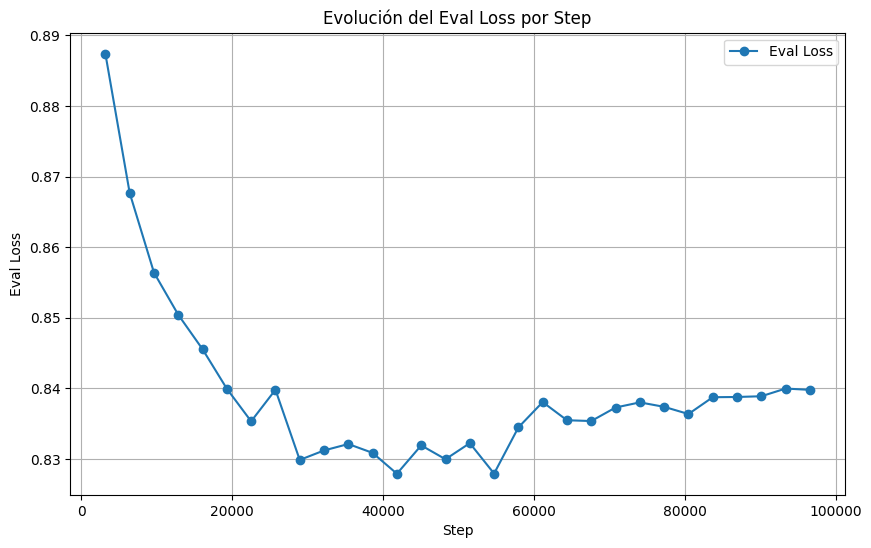

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo
log_df = pd.read_csv("training_log_2.csv")

# Filtrar solo entradas con eval_loss
eval_logs = log_df[log_df["eval_loss"].notna()]

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(eval_logs["step"], eval_logs["eval_loss"], marker="o", label="Eval Loss")
plt.title("Evolución del Eval Loss por Step")
plt.xlabel("Step")
plt.ylabel("Eval Loss")
plt.grid(True)
plt.legend()
plt.show()


## Evaluar Métricas con BLEU, ROUGE y METEOR

In [22]:
pip install evaluate nltk rouge-score

Note: you may need to restart the kernel to use updated packages.


In [20]:
import evaluate
import pandas as pd
import nltk
nltk.download('punkt')  # necesario para METEOR

# Cargar tu dataset comentado
df = pd.read_json("dataset_train_filtrado.jsonl", lines=True)

# Referencias y predicciones
references = df["code"].tolist()
predictions = df["code_clean"].tolist()

# Inicializar métricas
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Evaluar
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
meteor_score = meteor.compute(predictions=predictions, references=references)

print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)
print("METEOR:", meteor_score)


[nltk_data] Downloading package punkt to /home/frank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/frank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/frank/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/frank/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


BLEU: {'bleu': 0.5638528239702836, 'precisions': [0.984636269751521, 0.9475494914717164, 0.9124499076709959, 0.8788409035666468], 'brevity_penalty': 0.6062705930826014, 'length_ratio': 0.6664761125547475, 'translation_length': 754309, 'reference_length': 1131787}
ROUGE: {'rouge1': np.float64(0.7245312975882267), 'rouge2': np.float64(0.6892831967682362), 'rougeL': np.float64(0.7243242123330157), 'rougeLsum': np.float64(0.7244131796300642)}
METEOR: {'meteor': np.float64(0.5752045268753285)}


In [30]:
!pip install codebleu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.2/546.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [codebleu]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from tqdm import tqdm
import nltk
import evaluate

nltk.download("punkt")  # Necesario para METEOR

# Cargar modelo y tokenizer
model_path = "flan-t5-best-model-2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Cargar dataset
df = pd.read_json("dataset_train_filtrado.jsonl", lines=True)
df = df[:100]

# Generar predicciones
preds = []
for code_clean in tqdm(df["code_clean"].tolist(), desc="Generando comentarios"):
    prompt = f"Actúa como un desarrollador senior. Agrega docstring y comentarios al siguiente código manteniendo su formato original:\n\n{code_clean}"
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
    outputs = model.generate(**inputs, max_length=512)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    preds.append(pred)

# Referencias
refs = df["code"].tolist()

# Evaluar con métricas estándar
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

bleu_score = bleu.compute(predictions=preds, references=refs)
rouge_score = rouge.compute(predictions=preds, references=refs)
meteor_score = meteor.compute(predictions=preds, references=refs)

print("BLEU:", bleu_score)
print("ROUGE:", rouge_score)
print("METEOR:", meteor_score)


[nltk_data] Downloading package punkt to /home/frank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Generando comentarios: 100%|██████████████████| 100/100 [20:09<00:00, 12.09s/it]
[nltk_data] Downloading package wordnet to /home/frank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/frank/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/frank/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



🔍 BLEU: {'bleu': 0.07043869345035923, 'precisions': [0.4240479843771795, 0.35981177131619607, 0.3366105531192531, 0.3183501923350905], 'brevity_penalty': 0.19698378955650575, 'length_ratio': 0.3810055272108844, 'translation_length': 14338, 'reference_length': 37632}
🔍 ROUGE: {'rouge1': np.float64(0.21871031710006694), 'rouge2': np.float64(0.18405259955156628), 'rougeL': np.float64(0.21436999479380633), 'rougeLsum': np.float64(0.2182105766222578)}
🔍 METEOR: {'meteor': np.float64(0.1651664868641703)}


In [52]:
from IPython.display import display, HTML

texto = """
<div style='background-color:#5d2317; color:white; padding:2px 2px 2px 10px; font-family:monospace; line-height:1.2; margin:0'>
[nltk_data] Downloading package punkt to /home/frank/nltk_data...<br>
[nltk_data]   Package punkt is already up-to-date!<br>
Generando comentarios: 100%|██████████████████| 1000/<span style='color:#2ba7de'>1000</span> [55:09<00:00, 12.09s/<span style='color:#2ba7de'>it</span>]<br>
[nltk_data] Downloading package wordnet to /home/frank/nltk_data...<br>
[nltk_data]   Package wordnet is already up-to-date!<br>
[nltk_data] Downloading package punkt_tab to /home/frank/nltk_data...<br>
[nltk_data]   Package punkt_tab is already up-to-date!<br>
[nltk_data] Downloading package omw-1.4 to /home/frank/nltk_data...<br>
[nltk_data]   Package omw-1.4 is already up-to-date!<br>
</div>
"""
display(HTML(texto))
print("""BLEU: {'bleu': 0.5638528239702836, 'precisions': [0.984636269751521, 0.9475494914717164, 0.9124499076709959, 0.8788409035666468], 'brevity_penalty': 0.6062705930826014, 'length_ratio': 0.6664761125547475, 'translation_length': 754309, 'reference_length': 1131787}
ROUGE: {'rouge1': np.float64(0.7245312975882267), 'rouge2': np.float64(0.6892831967682362), 'rougeL': np.float64(0.7243242123330157), 'rougeLsum': np.float64(0.7244131796300642)}
METEOR: {'meteor': np.float64(0.5752045268753285)}
""")

BLEU: {'bleu': 0.5638528239702836, 'precisions': [0.984636269751521, 0.9475494914717164, 0.9124499076709959, 0.8788409035666468], 'brevity_penalty': 0.6062705930826014, 'length_ratio': 0.6664761125547475, 'translation_length': 754309, 'reference_length': 1131787}
ROUGE: {'rouge1': np.float64(0.7245312975882267), 'rouge2': np.float64(0.6892831967682362), 'rougeL': np.float64(0.7243242123330157), 'rougeLsum': np.float64(0.7244131796300642)}
METEOR: {'meteor': np.float64(0.5752045268753285)}



## Verificando formato y sintaxis con black + flake8

In [ ]:
import subprocess
from tempfile import NamedTemporaryFile

def check_format_with_black_flake8(code: str):
    try:
        with NamedTemporaryFile("w+", suffix=".py", delete=False) as tmp:
            tmp.write(code)
            tmp.flush()

            black_result = subprocess.run(["black", "--check", tmp.name], capture_output=True, text=True)
            flake_result = subprocess.run(["flake8", tmp.name], capture_output=True, text=True)

            print("🧪 BLACK:", "OK ✅" if black_result.returncode == 0 else black_result.stdout)
            print("🧪 FLAKE8:", "OK ✅" if flake_result.returncode == 0 else flake_result.stdout)

    except Exception as e:
        print(f"[ERROR] Fallo en la verificación: {e}")


## Verificar exactitud estructural con AST (Abstract Syntax Tree)

In [ ]:
import ast

def ast_equal(code1, code2):
    try:
        return ast.dump(ast.parse(code1)) == ast.dump(ast.parse(code2))
    except Exception:
        return False


## Guardar el modelo manualmente al final

In [21]:
# Esto guarda el modelo y el tokenizer
trainer.save_model("flan-t5-best-model-2")  
tokenizer.save_pretrained("flan-t5-best-model-2")


('flan-t5-best-model-2/tokenizer_config.json',
 'flan-t5-best-model-2/special_tokens_map.json',
 'flan-t5-best-model-2/tokenizer.json')

## Cargar el modelo luego para hacer inferencias

In [25]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("flan-t5-best-model-2")
tokenizer = AutoTokenizer.from_pretrained("flan-t5-best-model-2")

model.eval()  # modo evaluación


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k): lora.Lin

In [26]:
def generate_comment(code_clean):
    prompt = f"Act as a senior Python developer. Add docstring and then return the clean and formatted version of this Python function:\n\n{code_clean}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
    outputs = model.generate(**inputs, max_length=512)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Ejemplo
test_code = """
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True"""
print(generate_comment(test_code))


def is_prime(n): """ Check if a number is prime. :param n: The number of primes. :return: True if the number is prime. """ # Check if the number is prime if n = 1: return False for i in range(2, int(n**0.5) + 1): if n % i == 0: return False return True


In [ ]:
def is_prime(n): 
    """ Check if a number is prime. 
    :param n: The number of primes. 
    :return: True if the number is prime. """ 
    # Check if the number is prime 
    if n <= 1: 
        return False 
    for i in range(2, int(n**0.5) + 1): 
        if n % i == 0: 
            return False 
    return True

In [18]:
# ✅ Paso 12: Inferencia de ejemplo
#input_code = "def suma(a, b):\n    sumar = a + b\n    return sumar"
input_code = "def mcd_euclides(a, b):\n    while b:\n        a, b = b, a % b\n    return a"
#prompt = f"Add comments to the following Python code:\n{input_code}"
prompt = f"Add Python docstrings or comments to the following code and preserve indentation and line breaks:\n\n{input_code}"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

output_ids = model.generate(**inputs, max_new_tokens=512)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

def mcd_euclides(a, b): """Mcd Euclides is a b euclided by a a euclided by a b euclided by a c euclided by a d euclided by a e euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a c euclided by a d euclided by a 


In [ ]:
def mcd_euclides(a, b): 
    """ Given a list of Euclidean pairs, return the pair that is the parent of the given Euclidean pair. """ 
    # We have a pair of Euclidean pairs 
    while b: 
        a, b = b, a % b # We have a pair of Euclidean pairs 
        return a

In [20]:
# ✅ Paso 12: Inferencia de ejemplo
#input_code = "def suma(a, b):\n    sumar = a + b\n    return sumar"
input_code = """
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True
"""
#prompt = f"Add comments to the following Python code:\n{input_code}"
prompt = f"Add Python docstrings or comments to the following code and preserve indentation and line breaks:\n\n{input_code}"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

output_ids = model.generate(**inputs, max_new_tokens=256)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

def is_prime(n): """ Check if a number is prime. :param n: The number of primes in the range. :return: True if the number is prime. """ # Check if the number is prime if n = 1: return False # Check if the number is prime for i in range(2, int(n ** 0.5) + 1): if n % i == 0: return False return True


In [ ]:
def is_prime(n): """ Check if a number is prime. :param n: The number of primes in the range. :return: True if the number is prime. """ # Check if the number is prime if n = 1: return False # Check if the number is prime for i in range(2, int(n ** 0.5) + 1): if n % i == 0: return False return True

In [21]:
# ✅ Paso 11: Guardar el modelo final
trainer.save_model("flan-t5-large-eval_2")
tokenizer.save_pretrained("flan-t5-large-eval_2")

('flan-t5-large-eval_2/tokenizer_config.json',
 'flan-t5-large-eval_2/special_tokens_map.json',
 'flan-t5-large-eval_2/tokenizer.json')

In [20]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Ruta a tu modelo guardado
model_path = "flan-t5-large-eval_1"

# Cargar tokenizer y modelo desde el directorio
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [21]:
def generate_comment(code_clean, tokenizer, model, max_length=256):
    prompt = (
        #"You are an expert Python developer. "
        "Add detailed comments and a docstring to the following Python function:\n\n"
        f"{code_clean}\n\n### Return the commented version:"
    )
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_length=max_length)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [22]:
code_clean = """
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True
"""

print(generate_comment(code_clean, tokenizer, model))

def is_prime(n): """ Check if a number is prime. :param n: number of a number :type n: int :return: boolean """ # if n = 1: return False # check if i in range(2, int(n ** 0.5) + 1): if n % i == 0: return False # return True ### return the commented version


In [ ]:
# Only return the formatted code.

In [ ]:
def is_prime(n): 
    """Check if a number is prime. 
    This function checks if the number is prime, and if it is, it returns True if it is. 
    If it is not, it returns False. 
    Args: n (int): The number to check. 
    Returns: bool: True if the number is prime, 
    False otherwise. """ 
    if n = 1: 
        return False # Check if the number is prime 
    for i in range(2, int(n ** 0.5) + 1): 
        if n % i == 0: 
            return False # Check if the number is prime # Return True if it is. """ # Check if the number is prime for i in range(2, int(n ** 0.5) + 1): if n % i == 0: return False # Check if the number is prime # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True # Return True #